# ベースラインの実装
pytorchでの実装を行う。単純に

In [1]:
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import time 

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [16:02:40] Enabling RDKit 2019.09.3 jupyter extensions
[16:02:40] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

In [4]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split

In [5]:
dataset_df = pd.read_csv("../datasets/dataset.csv")
for col in dataset_df.columns:
    if col == "SMILES":
        continue
    dataset_df[col] = dataset_df[col].fillna(0)
dataset_df.head()

,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def get_morgan_fingerprint(smile, radius=2, bits=1024):
    mol_ = Chem.MolFromSmiles(smile)
    bit_morgan_ = {}
    if mol_ == None:
        return [0] * bits
    else:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol_, radius=radius, nBits=bits, bitInfo=bit_morgan_)
    return np.array(fp)

In [7]:
%%time
# 5min need
dataset_df["morgan_fingerprint"] = dataset_df["SMILES"].map(get_morgan_fingerprint)
dataset_df.head()

CPU times: user 4min 21s, sys: 972 ms, total: 4min 22s
Wall time: 4min 22s


,SMILES,λmax,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,morgan_fingerprint
0,c1cc2c(cn1)CCc1c[nH]nc1-2,263.321241,4.245324,1.073935,4.245324,1.073935,0.653297,171.203,162.131,171.079647,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CONC(=O)c1n[nH]c2c1CCc1n[nH]cc1-2,243.668931,11.685965,-0.336162,11.685965,0.336162,0.645013,233.231,222.143,233.091275,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C(O)c1[nH]nc2c1CCc1cnccc1-2,221.607321,10.962397,-0.952541,10.962397,0.205984,0.750319,215.212,206.140,215.069477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,OCc1[nH]nc2c1CCc1cnccc1-2,221.009049,9.146874,0.030506,9.146874,0.030506,0.724880,201.229,190.141,201.090212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1C=CC2=C3NNC(C(=O)O)=C3CC2=C1,468.999688,11.186579,-0.992914,11.186579,0.051150,0.581430,216.196,208.132,216.053492,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1024+208, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
model = Model()
model

Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1232, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [10]:
# データセットの定義と分割
X = np.array(dataset_df["morgan_fingerprint"].values.tolist())
X_rest = dataset_df.drop(['SMILES','λmax',"morgan_fingerprint"], axis=1).values
X = np.hstack([X, X_rest])
y = dataset_df["λmax"].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

y_train_mean, y_train_std = np.mean(y_train), np.std(y_train)
y_train = (y_train - y_train_mean) / y_train_std

# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [11]:
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# X_val = torch.FloatTensor(X_val)

In [12]:
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)
# y_val = torch.FloatTensor(y_val)

In [13]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)
# val_dataset = torch.utils.data.TensorDataset(X_val,y_val)

In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

In [15]:
device = torch.device("cuda:1" if torch.cuda.is_available() else 'cpu')
print("GPUを使っているかどうか？    {}".format(torch.cuda.is_available()))

GPUを使っているかどうか？    True


In [16]:
model = Model().to(device)

epochs = 1000
optimizer = optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)
losses = []
scores = []
start_time = time.perf_counter()

for epoch in range(epochs):
    
    total_loss = 0.0
    if epoch == 0:
        print("開始時間: {}".format(time.perf_counter() - start_time))
    
    model.train()
    for num, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_function = nn.MSELoss()
        outputs = outputs.reshape(-1)
        loss = loss_function(outputs, labels)
        # model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if not (loss.item() > 0):
            print(num, outputs, loss.item)
            break
    # with open(OUTPUTPATH + "loss/"+VERSION+".txt", mode="a") as f:
    #     f.write(str(round(total_loss,3)) + "\n")
            
    model.eval()
    actual_labels, pred_labels = np.empty(0), np.empty(0)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs * y_train_std + y_train_mean
        labels, outputs = labels.reshape(-1), outputs.reshape(-1)
        actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
        pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])
    score = mse(actual_labels, pred_labels)

    print("経過時間: {}, epoch数: {}, loss: {}, score: {}".format(
        round(time.perf_counter() - start_time, 3),
        epoch, 
        round(total_loss,3),
        round(score, 3)))
    
    if epoch >100 and total_loss > np.mean(losses[-10:]):
        scores.append(score)
        losses.append(total_loss)
        break
    losses.append(total_loss)
    scores.append(score)

開始時間: 0.0003624632954597473
経過時間: 17.563, epoch数: 0, loss: 4032.042, score: 671.564
経過時間: 33.979, epoch数: 1, loss: 3662.781, score: 663.05
経過時間: 49.284, epoch数: 2, loss: 3543.764, score: 687.278
経過時間: 65.377, epoch数: 3, loss: 3473.026, score: 646.522
経過時間: 80.653, epoch数: 4, loss: 3444.059, score: 649.553
経過時間: 95.996, epoch数: 5, loss: 3408.246, score: 645.613
経過時間: 111.329, epoch数: 6, loss: 3352.055, score: 644.636
経過時間: 125.707, epoch数: 7, loss: 3316.016, score: 637.167
経過時間: 141.201, epoch数: 8, loss: 3293.63, score: 632.069
経過時間: 156.988, epoch数: 9, loss: 3263.148, score: 622.296
経過時間: 172.106, epoch数: 10, loss: 3242.299, score: 603.196
経過時間: 187.517, epoch数: 11, loss: 3214.956, score: 596.988
経過時間: 203.233, epoch数: 12, loss: 3196.558, score: 599.574
経過時間: 218.418, epoch数: 13, loss: 3172.979, score: 591.003
経過時間: 234.927, epoch数: 14, loss: 3148.797, score: 669.645
経過時間: 250.739, epoch数: 15, loss: 3148.043, score: 648.134
経過時間: 266.861, epoch数: 16, loss: 3117.128, score: 643.291
経過時間

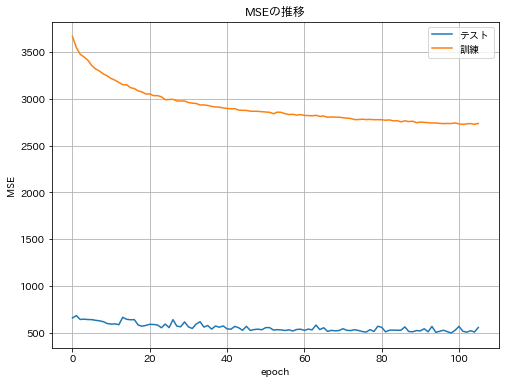

In [17]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()

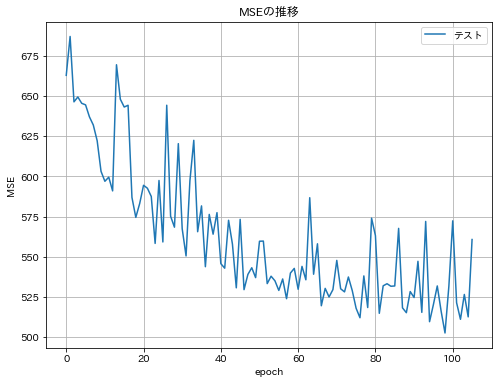

In [18]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
# ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()

In [19]:
model = Model().to(device)

epochs = 1000
optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)
losses = []
scores = []
start_time = time.perf_counter()

for epoch in range(epochs):
    
    total_loss = 0.0
    if epoch == 0:
        print("開始時間: {}".format(time.perf_counter() - start_time))
    
    model.train()
    for num, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss_function = nn.MSELoss()
        outputs = outputs.reshape(-1)
        loss = loss_function(outputs, labels)
        # model.zero_grad()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if not (loss.item() > 0):
            print(num, outputs, loss.item)
            break
    # with open(OUTPUTPATH + "loss/"+VERSION+".txt", mode="a") as f:
    #     f.write(str(round(total_loss,3)) + "\n")
            
    model.eval()
    actual_labels, pred_labels = np.empty(0), np.empty(0)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        outputs = outputs * y_train_std + y_train_mean
        labels, outputs = labels.reshape(-1), outputs.reshape(-1)
        actual_labels = np.concatenate([actual_labels, np.array(labels.cpu().numpy())])
        pred_labels = np.concatenate([pred_labels, np.array(outputs.cpu().detach().numpy())])
    score = mse(actual_labels, pred_labels)

    print("経過時間: {}, epoch数: {}, loss: {}, score: {}".format(
        round(time.perf_counter() - start_time, 3),
        epoch, 
        round(total_loss,3),
        round(score, 3)))
    
    if epoch >100 and total_loss > np.mean(losses[-10:]):
        scores.append(score)
        losses.append(total_loss)
        break
    losses.append(total_loss)
    scores.append(score)

開始時間: 0.0007889717817306519
経過時間: 16.73, epoch数: 0, loss: 7122.45, score: 749.905
経過時間: 33.591, epoch数: 1, loss: 3524.992, score: 637.659
経過時間: 50.022, epoch数: 2, loss: 3410.799, score: 628.75
経過時間: 67.161, epoch数: 3, loss: 3322.686, score: 607.554
経過時間: 84.071, epoch数: 4, loss: 3239.373, score: 604.186
経過時間: 99.631, epoch数: 5, loss: 3219.509, score: 606.017
経過時間: 115.99, epoch数: 6, loss: 3150.867, score: 588.131
経過時間: 132.707, epoch数: 7, loss: 3154.675, score: 599.494
経過時間: 149.386, epoch数: 8, loss: 3119.515, score: 595.044
経過時間: 166.835, epoch数: 9, loss: 3089.525, score: 566.733
経過時間: 183.037, epoch数: 10, loss: 3078.351, score: 563.642
経過時間: 199.041, epoch数: 11, loss: 3064.962, score: 583.629
経過時間: 214.12, epoch数: 12, loss: 3046.245, score: 568.995
経過時間: 229.873, epoch数: 13, loss: 3033.448, score: 596.207
経過時間: 246.938, epoch数: 14, loss: 3037.838, score: 596.275
経過時間: 263.688, epoch数: 15, loss: 3014.32, score: 567.743
経過時間: 280.347, epoch数: 16, loss: 3008.947, score: 621.466
経過時間: 29

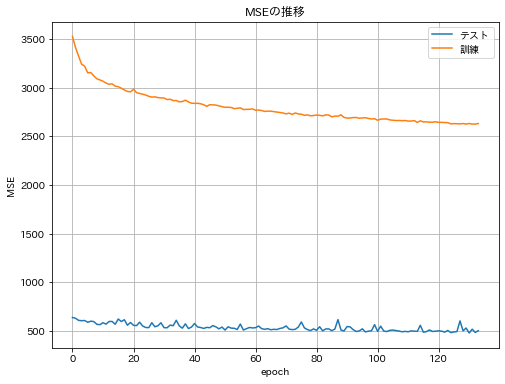

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()

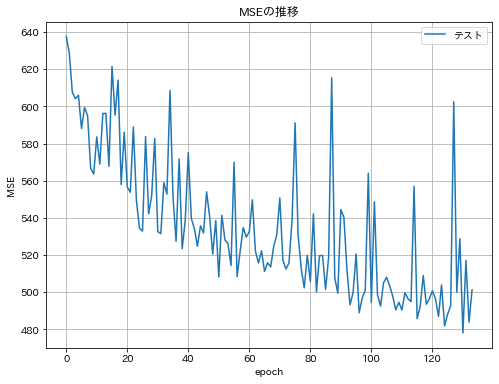

In [21]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(len(scores)-1), scores[1:], label="テスト")
# ax.plot(range(len(scores)-1), losses[1:], label="訓練")
ax.set_xlabel("epoch")
ax.set_ylabel("MSE")
ax.set_title("MSEの推移")
ax.legend()
ax.grid()